In [1]:
import dadrah.analysis.root_plotting_util as rpu
import dadrah.util.run_paths as runpa
import dadrah.util.string_constants as stco
import dadrah.selection.selection_util as seut
import pofah.util.sample_factory as sf
import pofah.jet_sample as js
import pofah.util.utility_fun as utfu
import pofah.util.experiment as exp
import dadrah.kfold_pipeline.kfold_util as kutil
import dadrah.kfold_pipeline.kfold_string_constants as kstco

import pathlib
import argparse
from typing import List

import numpy as np
import ROOT as rt
import root_numpy as rtnp
import uuid
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import root_numpy as rtnp
import mplhep as hep
plt.style.use(hep.style.ROOT)
from typing import List
from recordtype import recordtype

Welcome to JupyROOT 6.22/00


## run config params

In [2]:
Parameters = recordtype('Parameters','qr_run_n, quantiles, qcd_sample_id, sig_sample_id, sig_xsec, score_strategy_id, read_n, binning, env_run_n, poly_run_n')
params = Parameters(qr_run_n=408,
                    quantiles=[0.3, 0.5, 0.7, 0.9],
                    qcd_sample_id='qcdSigAll', 
                    sig_sample_id='GtoWW35naReco',
                    sig_xsec=0,
                    score_strategy_id='rk5_05',
                    read_n=None,
                    binning='dijet',
                    env_run_n=0,
                    poly_run_n=0,
                    )

ae_run_n = 113
#qr_run_n, qr_model_str = 4, 'poly'
#qr_run_n, qr_model_str = 5, 'bernstein'
#qr_run_n, qr_model_str = 7, 'dense'
#qr_run_n, qr_model_str = 7, 'dense_polyfit'
#qr_run_n, qr_model_str = 8, 'dense_70pct_train'
#qr_run_n, qr_model_str, train_share = 31, 'dense_kfold', 0
#qr_run_n, qr_model_str, train_share = 34, 'dense_kfold_lmfit11', 0 # => current best
#qr_run_n, qr_model_str, train_share = 189, 'dense_kfold_binned_ratio', 0
#qr_run_n, qr_model_str, train_share = 191, 'dense_kfold_global_ratio', 0
qr_model_str, train_share = '_'.join(['kfold',str(params.qr_run_n),str(params.env_run_n),str(params.poly_run_n)]), 0

xsec = 0
mX = 3.5
sample_id_qcd = 'qcdSigAllTest'+str(int((1-train_share)*100))+'pct' if train_share else 'qcdSigAll'
sample_id_sig = 'GtoWW35naReco'
sample_ids = [sample_id_qcd, sample_id_sig]
#quantiles = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
#quantiles = [0.3, 0.5, 0.7, 0.9]
#quantiles = [0.5, 0.9]
#quantiles = [0.1, 0.5, 0.99]

# choose which template quantile to use (0 = 0.9-1.0, 1 = 0.7-0.9)
template_q_idx = 0
poly_cut = True

# paths
input_path = kstco.get_polynomials_out_data_dir(params)
fig_dir = 'fig/qr_run_'+str(int(params.qr_run_n))+'/env_run_'+str(int(params.env_run_n))+'/poly_run_'+str(int(params.poly_run_n))
pathlib.Path(fig_dir).mkdir(parents=True, exist_ok=True)

## read in data

In [3]:
# old paths:
# if poly_cut:
#     paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections_poly_cut'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
#     path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_ids[1][:-4], 'xsec': str(int(xsec)), 'loss': 'rk5_05', 'order':'5'}
# else:
#     paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
#     path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_ids[1], 'xsec': str(int(xsec)), 'loss': 'rk5_05'}

# paths.extend_in_path_data(path_ext_dict)
# paths.extend_out_path_data({**path_ext_dict, 'mjj_spectra': None, 'orthogonal': None})


samples = {}

for sample_id in sample_ids:
    in_path = os.path.join(input_path,sample_id+'.h5') #paths.in_file_path(sample_id)
    samples[sample_id] = js.JetSample.from_input_file(sample_id, in_path)
    print('read ' + str(len(samples[sample_id])) + ' ' + sample_id + ' samples from ' + in_path)

read 11985958 qcdSigAll samples from /eos/user/k/kiwoznia/data/QR_results/events/qr_run_408/env_run_0/poly_run_0/qcdSigAll.h5
read 531825 GtoWW35naReco samples from /eos/user/k/kiwoznia/data/QR_results/events/qr_run_408/env_run_0/poly_run_0/GtoWW35naReco.h5


In [4]:
samples_ortho_quantiles = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_qcd], params.quantiles)

mjj_vals = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles]

In [5]:
q_str = [str(q) for q in [0.]+params.quantiles+[1.]]

In [6]:
q_str

['0.0', '0.3', '0.5', '0.7', '0.9', '1.0']

In [7]:
len(mjj_vals)

5

In [8]:
num_samples = sum(map(len,mjj_vals))
print(num_samples)

11985958


In [9]:
for q_i, q_ii, mjj in zip(q_str[:-1], q_str[1:], mjj_vals):
    print(q_i + '-'+ q_ii + ': ' + str(len(mjj)) + ' ({:.3f})'.format(len(mjj)/num_samples))

0.0-0.3: 3561019 (0.297)
0.3-0.5: 2431563 (0.203)
0.5-0.7: 2399624 (0.200)
0.7-0.9: 2393521 (0.200)
0.9-1.0: 1200231 (0.100)


In [10]:
params

Parameters(qr_run_n=407, quantiles=[0.3, 0.5, 0.7, 0.9], qcd_sample_id='qcdSigAll', sig_sample_id='GtoWW35naReco', sig_xsec=0, score_strategy_id='rk5_05', read_n=None, binning='dijet', env_run_n=0, poly_run_n=0)

In [11]:
min_mjj = 1200.
max_mjj = 6800. #5600
bin_edges = kutil.get_bins_from_envelope(params)
bin_edges = bin_edges[bin_edges>=min_mjj && bin_edges<=max_mjj]

print('min_mjj='+str(min_mjj) + ', max_mjj='+str(max_mjj))
print('bin edges')
print(bin_edges)

n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

min_mjj=1287.5, max_mjj=6800.0


In [12]:
cmap = cm.get_cmap('winter')
cmap = [mpl.colors.rgb2hex(c) for c in cmap(np.linspace(0.0, 1.0, len(mjj_vals)+1))][1:]

## read data into histograms

In [13]:
n_bins = len(bin_edges)-1 #50
#min_bin = min([np.min(mjj) for mjj in mjj_vals])
#max_bin = max([np.max(mjj) for mjj in mjj_vals])
hist_sz = 700
marker_sty = 8
marker_sz = 0.7

In [14]:
# template / bottom histogram
props={'LineColor': rt.kBlack, "YTitle": 'num events', "XTitle": "M_{jj} [GeV]", "Title":"", "Minimum": 0.2, "Maximum": num_samples*1.1}
ht = rpu.create_hist(mjj_vals[template_q_idx],'',n_bins, bin_edges.astype('float'), props=props)

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [15]:
# other ortho quantile hists
hh = []
for mjj,c in zip(mjj_vals[template_q_idx+1:], cmap[template_q_idx:]):
    props = {"LineColor": rt.TColor.GetColor(c), "MarkerColor": rt.TColor.GetColor(c), "LineWidth": 1, "MarkerStyle": marker_sty, "MarkerSize": marker_sz}
    h = rpu.create_hist(mjj, '', n_bins, bin_edges.astype('float'), props=props)
    hh.append(h)

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [16]:
len(hh)

4

In [17]:
# create ratio histograms
hr = []
for h, c in zip(hh, cmap[template_q_idx:]):
    props={"LineColor": rt.TColor.GetColor(c), "MarkerColor": rt.TColor.GetColor(c), "Title": '', "LineWidth": 1, "MarkerStyle": marker_sty}
    r = rpu.create_ratio_hist(h,ht,props=props)
    hr.append(r)
rpu.set_style(hr[0], props={ "XTitle": 'M_{jj} [GeV]', "YTitle": "ratio SIG / BG"})

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


## draw figure

In [18]:
import cmsstyle #mplhep for Python2 cheatsheet
c_out, pad1, pad2 = rpu.create_canvas_pads(pad_props={'LeftMargin': 0.13})
# legend
leg = rpu.create_object("TLegend", 0.62, 0.5, 0.85, 0.78)
leg_h = rpu.create_object("TLegend", 0.4, 0.8, 0.95, 0.85) # second legend for header because left align not available
rpu.set_style(leg,props={'TextSize': 0.045})
rpu.set_style(leg_h,props={'TextSize': 0.045})

In [19]:
pad1.cd()
# draw template histogram
ht.Draw('HIST')
rpu.set_style(ht.GetYaxis(), props={'TitleSize':0.05, 'LabelSize':0.05, 'TitleOffset':0.95, 'Ndivisions':304})
leg.AddEntry(ht, 'q = '+q_str[template_q_idx+1]+'-'+q_str[template_q_idx], 'lep')

In [20]:
# draw remaining histograms
for h in hh:
    h.Draw('pez same')
ht.Draw('hist same') # draw once more on top

In [21]:
for h, qi, qii in zip(hh, q_str[template_q_idx+2:], q_str[template_q_idx+1:]):
    leg.AddEntry(h, 'q = {} - {}'.format(qi,qii), 'lep')

leg_h.SetHeader(r'Data: QCD MC + G_{RS}(%.1fTeV,#sigma=%i fb)'%(mX,xsec))
leg.Draw()
leg_h.Draw()

In [22]:
pad2.cd()
hr[0].Draw('pe')
ratio_min, ratio_max = 0.8, 1.2
props={'YTitle':'#frac{#epsilon#timesq}{q_{0.3-0.0}}', 'XTitle':'M_{jj} (GeV)', 'Maximum':ratio_max, 'Minimum':ratio_min, 'TitleOffset':0.4}
rpu.set_style(hr[0],props=props)
rpu.set_style(hr[0].GetYaxis(),props={'TitleSize':0.12, 'LabelSize':0.12, 'Ndivisions':304, 'TitleOffset':0.4 })
rpu.set_style(hr[0].GetXaxis(),props={'TitleSize':0.12, 'LabelSize':0.12, 'Ndivisions':304, 'TitleOffset':0.95, 'Ndivisions':909, 'TickSize':0.07 })
hr[0].GetYaxis().CenterTitle()

for r in hr[1:]:
    r.Draw('pe same')

In [23]:
eff_line = rpu.create_ratio_line(hr[0])
eff_line.Draw('same')

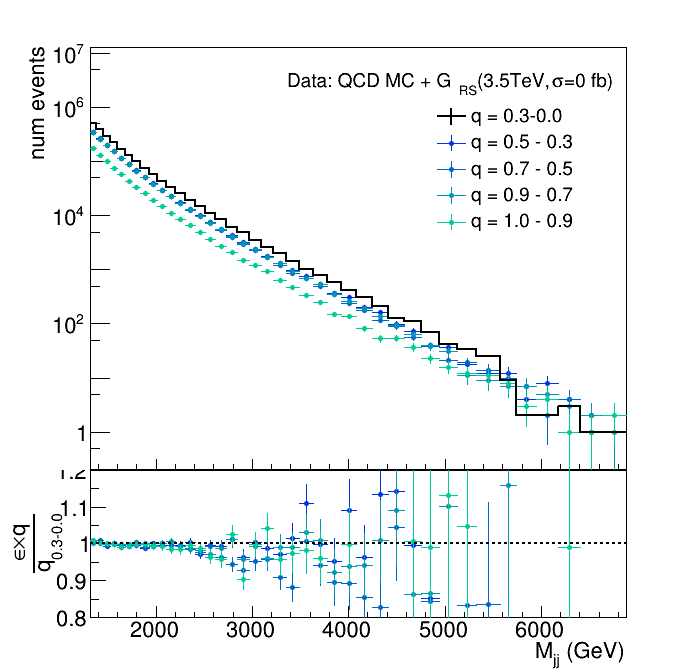

In [24]:
c_out.Draw()

In [25]:
template_str = ('q'+q_str[template_q_idx+1]+'_q'+q_str[template_q_idx]).replace('.', '')
c_out.SaveAs(fig_dir+'/mjj_ratio_xsec0_{}_{}_binning_{}_template.pdf'.format(qr_model_str, 'dijet' if dijet_binning else 'linspace', template_str))

Info in <TCanvas::Print>: pdf file fig/qr_run_406/env_run_0/poly_run_0/mjj_ratio_xsec0_kfold_406_0_0_dijet_binning_q03_q00_template.pdf has been created
